In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [3]:
# Definicija putanja za treniranje i test
# iranje
data_path = 'data_set'  # Promeni putanju ako je drugačija
train_path = os.path.join(data_path, 'train')  # Ispravio putanju
test_path = os.path.join(data_path, 'test')  # Ispravio putanju

In [4]:
# Data augmentacija i transformacije
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Nasumično horizontalno ogledanje
    transforms.RandomVerticalFlip(),  # **Nova augmentacija: Nasumično vertikalno ogledanje**
    transforms.RandomRotation(10),  # Nasumična rotacija do 10 stepeni
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # **Nova augmentacija: Promene boje**
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Učitavanje podataka
train_dataset = ImageFolder(root=train_path, transform=transform_train)
test_dataset = ImageFolder(root=test_path, transform=transform_test)

# Kreiranje DataLoader-a sa manjim batch size
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)  # **Smanjen batch size**
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Kreiranje ResNet18 modela
model = models.resnet18(pretrained=True)

# Prilagođavanje zadnjeg sloja za našu klasifikaciju
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # 4 klase: glioma, meningioma, no tumor, pituitary

# Provera dostupnosti CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Definisanje funkcije gubitka i optimizatora (koristi Adam umesto SGD)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # **Koristi Adam i dodaj L2 regularizaciju**

# **Dodaj Learning Rate Scheduler**
from torch.optim import lr_scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Funkcija za treniranje modela
def train_model(model, train_loader, test_loader, criterion, optimizer, device, scheduler, num_epochs=20):  # **Povećaj broj epoha**
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validacija
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(test_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        # **Dodaj Scheduler Step**
        scheduler.step()

        print(f'Epoha {epoch+1}/{num_epochs}, Trening gubitak: {epoch_loss:.4f}, Validacioni gubitak: {val_loss:.4f}, '
              f'Trening tačnost: {train_accuracy:.2f}%, Validaciona tačnost: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies


/home/teki/Documents/brain_mri/venv_master/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/teki/Documents/brain_mri/venv_master/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/teki/Documents/brain_mri/venv_master/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be

In [5]:
# Treniranje modela
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, device, scheduler)


Epoha 1/20, Trening gubitak: 0.5193, Validacioni gubitak: 0.2864, Trening tačnost: 80.95%, Validaciona tačnost: 89.09%
Epoha 2/20, Trening gubitak: 0.3273, Validacioni gubitak: 0.3366, Trening tačnost: 88.48%, Validaciona tačnost: 86.96%
Epoha 3/20, Trening gubitak: 0.2344, Validacioni gubitak: 0.2185, Trening tačnost: 91.53%, Validaciona tačnost: 91.30%
Epoha 4/20, Trening gubitak: 0.2368, Validacioni gubitak: 0.2330, Trening tačnost: 91.65%, Validaciona tačnost: 92.07%
Epoha 5/20, Trening gubitak: 0.2149, Validacioni gubitak: 0.2174, Trening tačnost: 92.61%, Validaciona tačnost: 92.22%
Epoha 6/20, Trening gubitak: 0.1045, Validacioni gubitak: 0.0823, Trening tačnost: 96.41%, Validaciona tačnost: 96.34%
Epoha 7/20, Trening gubitak: 0.0800, Validacioni gubitak: 0.0464, Trening tačnost: 97.34%, Validaciona tačnost: 98.25%
Epoha 8/20, Trening gubitak: 0.0688, Validacioni gubitak: 0.0418, Trening tačnost: 97.78%, Validaciona tačnost: 98.55%
Epoha 9/20, Trening gubitak: 0.0586, Validacioni

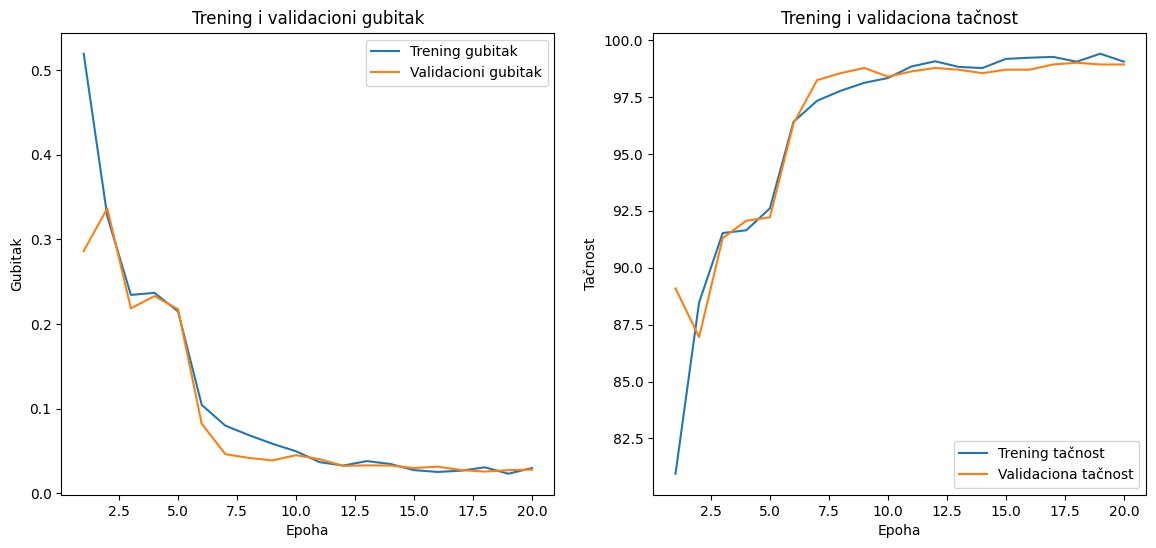

In [6]:
# Crtanje grafika za gubitak i tačnost
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Trening gubitak')
    plt.plot(epochs, val_losses, label='Validacioni gubitak')
    plt.xlabel('Epoha')
    plt.ylabel('Gubitak')
    plt.title('Trening i validacioni gubitak')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Trening tačnost')
    plt.plot(epochs, val_accuracies, label='Validaciona tačnost')
    plt.xlabel('Epoha')
    plt.ylabel('Tačnost')
    plt.title('Trening i validaciona tačnost')
    plt.legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


In [7]:
# Evaluacija modela
def evaluate_model_with_report(model, test_loader, device, class_names):
    model.eval()  # Evaluacioni mod
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct_test / total_test
    print(f'Test gubitak: {test_loss:.4f}, Test tačnost: {test_accuracy:.2f}%')
    
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

Test gubitak: 0.0281, Test tačnost: 98.93%

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       300
  meningioma       0.97      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



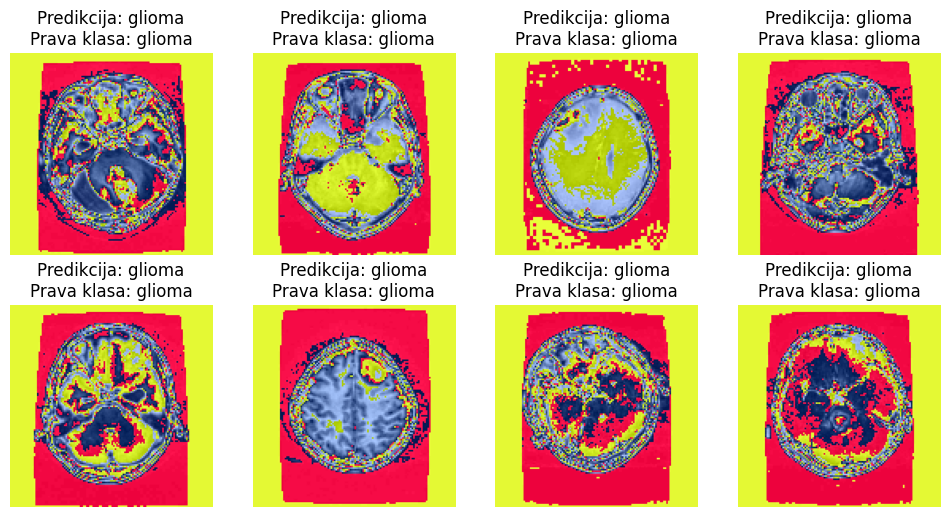

In [8]:
# Imena klasa
class_names = train_dataset.classes
evaluate_model_with_report(model, test_loader, device, class_names)

# Prikaz slika sa predikcijama
def show_predictions(model, dataloader, class_names, device):
    model.eval()
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    fig = plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        ax = plt.subplot(2, 4, idx+1)
        img = transforms.ToPILImage()(images[idx].cpu())
        ax.imshow(img)
        ax.set_title(f'Predikcija: {class_names[preds[idx]]}\nPrava klasa: {class_names[labels[idx]]}')
        ax.axis('off')
    plt.show()

show_predictions(model, test_loader, class_names, device)